In [ ]:
# !pip install kaggle
# api_token = {'username':'','key':''}
# import json
# with open('/content/kaggle.json', 'w') as file:
#     json.dump(api_token, file)
# !mkdir -p ~/.kaggle 
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets download -d kritikseth/fruit-and-vegetable-image-recognition
# !unzip /content/fruit-and-vegetable-image-recognition.zip -d foodimages

In [ ]:
import os
import pandas as pd
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
base_folder = '/content/foodimages'

for root, dirs, files in os.walk(base_folder, topdown=False):
   for name in dirs:
      categories = os.listdir(os.path.join(root, name))

ids = list(range(len(categories)))
cat_id = {cat:id for cat, id in zip(categories, ids)}

In [ ]:
train_path = base_folder + '/train'
test_path = base_folder + '/test'
valid_path = base_folder + '/validation'

train_paths = [train_path+'/'+category for category in categories]
test_paths = [test_path+'/'+category for category in categories]
valid_paths = [valid_path+'/'+category for category in categories]

In [ ]:
paths = []
for path in train_paths:
    paths.append([path+'/'+p for p in os.listdir(path)])

train_all_paths = [item for sublist in paths for item in sublist]

paths = []
for path in test_paths:
    paths.append([path+'/'+p for p in os.listdir(path)])

test_all_paths = [item for sublist in paths for item in sublist]

paths = []
for path in valid_paths:
    paths.append([path+'/'+p for p in os.listdir(path)])

valid_all_paths = [item for sublist in paths for item in sublist]

In [ ]:
food_train = [filename.split('/')[4] for filename in train_all_paths]
food_test = [filename.split('/')[4] for filename in test_all_paths]
food_valid = [filename.split('/')[4] for filename in valid_all_paths]

In [ ]:
train = pd.DataFrame({'File': train_all_paths, 'Label': food_train})
# train['Label'] = train['Label'].replace(cat_id)
train.to_csv('food_train.csv',index=False)

test = pd.DataFrame({'File': test_all_paths, 'Label': food_test})
# test['Label'] = test['Label'].replace(cat_id)
test.to_csv('food_test.csv',index=False)

valid = pd.DataFrame({'File': valid_all_paths, 'Label': food_valid})
# valid['Label'] = valid['Label'].replace(cat_id)
valid.to_csv('food_valid.csv',index=False)

In [ ]:
train_datagen = ImageDataGenerator(rescale=1/255.0,
                                   rotation_range=10,
                                   zoom_range=0.1,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   horizontal_flip=True,
                                   fill_mode='nearest',
                                   validation_split=None)

valid_datagen = ImageDataGenerator(rescale=1/255.0,
                                   rotation_range=20,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest',
                                   validation_split=None)

test_datagen = ImageDataGenerator(rescale=1/255.0)

In [ ]:
batch_size = 20
img_rows, img_cols = (100, 100)
input_shape = (img_rows, img_cols, 3)
dir = ''


train_aug = train_datagen.flow_from_dataframe(dataframe=train,
                                              directory=dir,
                                              x_col='File',
                                              y_col='Label',
                                              batch_size=batch_size,
                                              target_size=(img_rows, img_cols),
                                              class_mode='categorical',
                                              shuffle=True,
                                              color_mode='rgb',
                                              seed=123)

valid_aug = valid_datagen.flow_from_dataframe(dataframe=valid,
                                              directory=dir,
                                              x_col='File',
                                              y_col='Label',
                                              batch_size=batch_size,
                                              target_size=(img_rows, img_cols),
                                              class_mode='categorical',
                                              shuffle=True,
                                              color_mode='rgb',
                                              seed=123)

test_aug = test_datagen.flow_from_dataframe(dataframe=test,
                                            directory=dir,
                                            x_col='File',
                                            y_col='Label',
                                            batch_size=batch_size,
                                            target_size=(img_rows, img_cols),
                                            class_mode='categorical',
                                            shuffle=False,
                                            color_mode='rgb')

Found 3581 validated image filenames belonging to 36 classes.
Found 351 validated image filenames belonging to 36 classes.
Found 359 validated image filenames belonging to 36 classes.


In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [ ]:
model = Sequential()

model.add(Conv2D(256, (3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))


model.add(Flatten())
model.add(Dense(units=512, activation='relu'))
model.add(Dense(units=36, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 98, 98, 256)       7168      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 49, 49, 256)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 47, 47, 256)       590080    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 23, 23, 256)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 21, 21, 128)       295040    
_________________________________________________________________
flatten_1 (Flatten)          (None, 56448)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)              

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [ ]:
from tensorgram import TensorGram
tf = TensorGram('model','805308003')

Epoch 1/40
  4/180 [..............................] - ETA: 1:45 - loss: 3.4947 - accuracy: 0.0625

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


 37/180 [=====>........................] - ETA: 1:42 - loss: 3.4341 - accuracy: 0.0770

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


180/180 [==============================] - 160s 887ms/step - loss: 3.2562 - accuracy: 0.1053 - val_loss: 2.8987 - val_accuracy: 0.1795
Epoch 2/40
180/180 [==============================] - 161s 894ms/step - loss: 2.9294 - accuracy: 0.1648 - val_loss: 2.7295 - val_accuracy: 0.1909
Epoch 3/40
180/180 [==============================] - 162s 903ms/step - loss: 2.6947 - accuracy: 0.2198 - val_loss: 2.4255 - val_accuracy: 0.2507
Epoch 4/40
180/180 [==============================] - 163s 908ms/step - loss: 2.6232 - accuracy: 0.2424 - val_loss: 2.7467 - val_accuracy: 0.2536
Epoch 5/40
180/180 [==============================] - 161s 894ms/step - loss: 2.5107 - accuracy: 0.2642 - val_loss: 2.2880 - val_accuracy: 0.3333
Epoch 6/40
180/180 [==============================] - 165s 915ms/step - loss: 2.4191 - accuracy: 0.2843 - val_loss: 2.1148 - val_accuracy: 0.3789
Epoch 7/40
180/180 [==============================] - 164s 913ms/step - loss: 2.3209 - accuracy: 0.3111 - val_loss: 1.9708 - val_accura

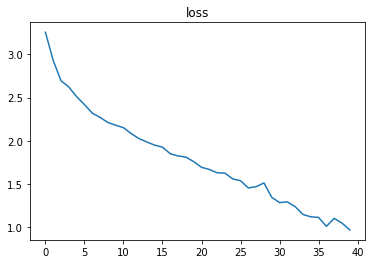

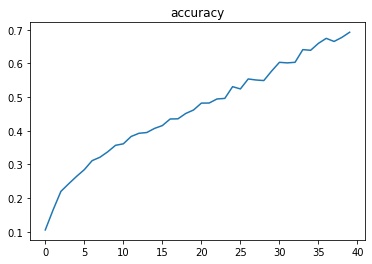

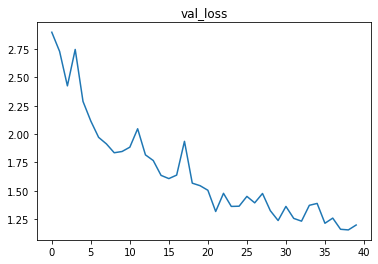

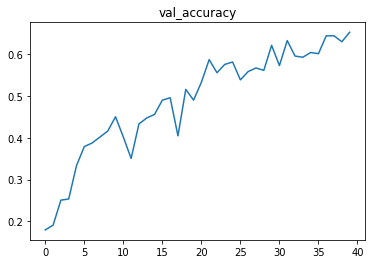

In [ ]:
history = model.fit(train_aug, validation_data=valid_aug, epochs=40)

In [ ]:
model.save('model.hdf5')